In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import yfinance as yf


[*********************100%***********************]  1 of 1 completed


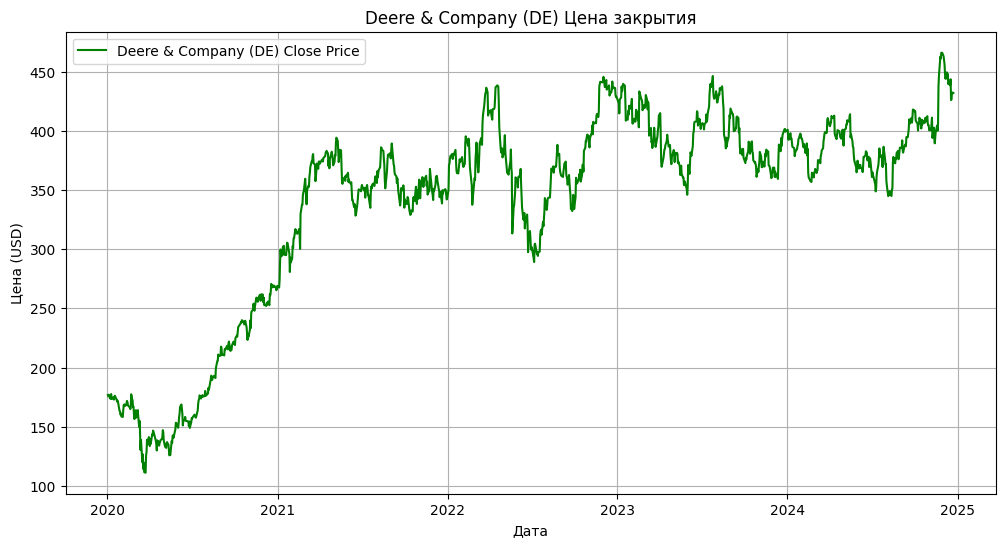

In [4]:
# Загрузка данных о ценах Deere & Company (DE) с Yahoo Finance
de_data = yf.download('DE', start='2020-01-01', end='2024-12-31')

de_close = de_data['Close']

plt.figure(figsize=(12, 6))
plt.plot(de_close, label='Deere & Company (DE) Close Price', color='green')
plt.title('Deere & Company (DE) Цена закрытия')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid()
plt.show()

[*********************100%***********************]  1 of 1 completed


Количество пропущенных значений: Ticker
DE    0
dtype: int64


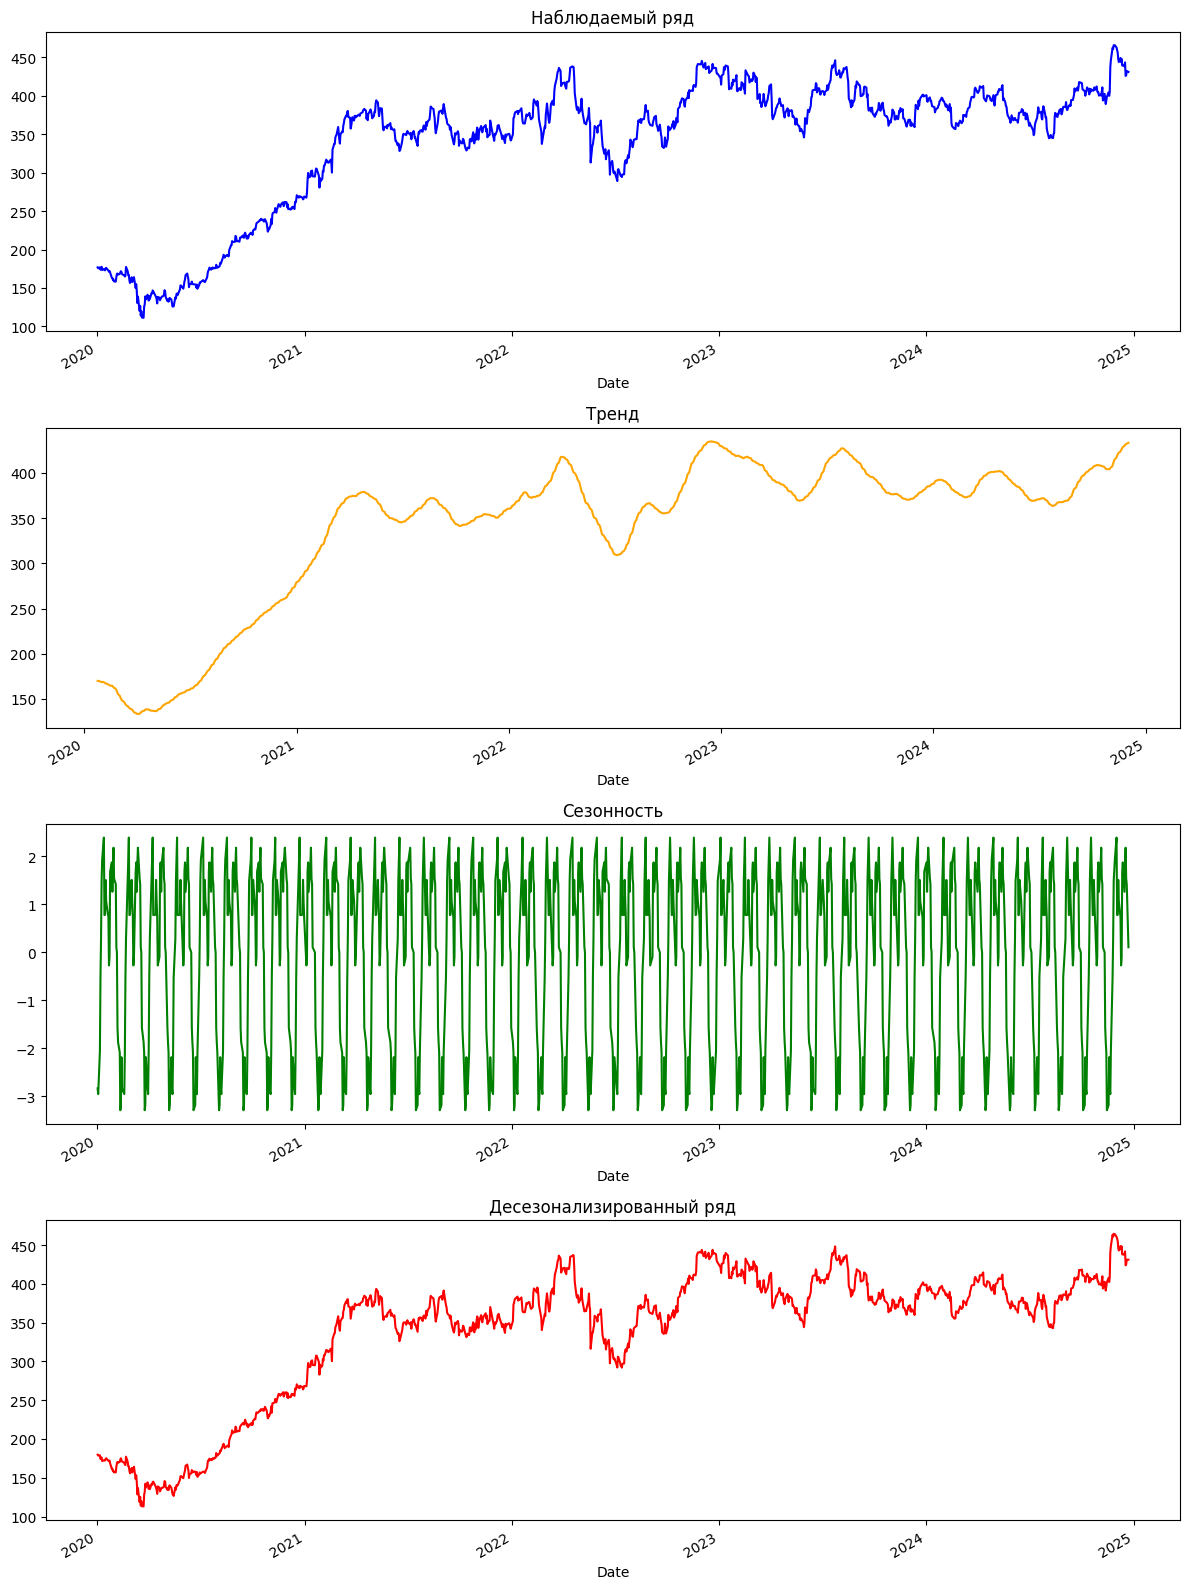

In [5]:
# Загрузка данных Deere & Company (DE)
de_data = yf.download('DE', start='2020-01-01', end='2024-12-31')


de_close = de_data['Close']


print("Количество пропущенных значений:", de_close.isna().sum())
de_close = de_close.interpolate(method='linear')
decomposition = seasonal_decompose(de_close, model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
decomposition.observed.plot(ax=ax1, color='blue')
ax1.set_title('Наблюдаемый ряд')
decomposition.trend.plot(ax=ax2, color='orange')
ax2.set_title('Тренд')
decomposition.seasonal.plot(ax=ax3, color='green')
ax3.set_title('Сезонность')
deseasonal = decomposition.observed - decomposition.seasonal
deseasonal.plot(ax=ax4, color='red')
ax4.set_title('Десезонализированный ряд')
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


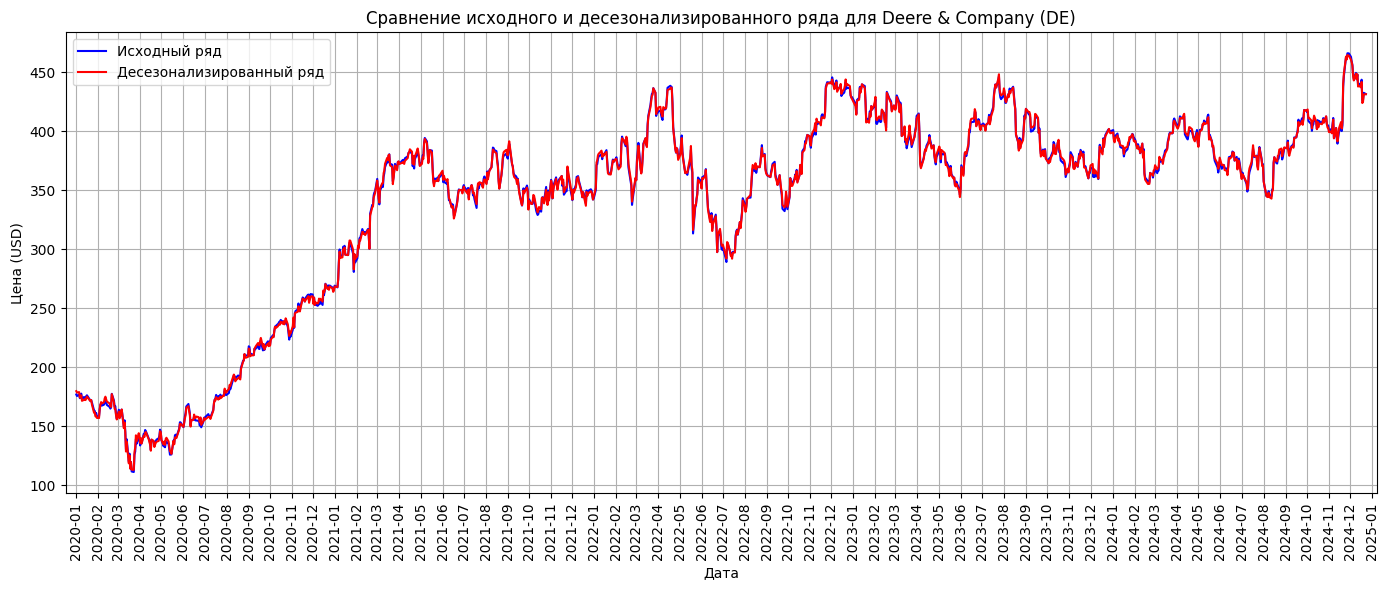

In [8]:
# Загрузка данных Deere & Company (DE)
de_data = yf.download('DE', start='2020-01-01', end='2024-12-31')


de_close = de_data['Close']


decomposition = seasonal_decompose(de_close, model='additive', period=30)


seasonal = decomposition.seasonal.dropna()
deseasonalized = decomposition.observed - seasonal


plt.figure(figsize=(14, 6))
plt.plot(de_data.index, de_close, label='Исходный ряд', color='blue')
plt.plot(deseasonalized.index, deseasonalized, label='Десезонализированный ряд', color='red')
plt.legend()
plt.title('Сравнение исходного и десезонализированного ряда для Deere & Company (DE)')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(de_data.index[0]-pd.Timedelta(days=15), de_data.index[-1]+pd.Timedelta(days=15))
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.grid(True)
plt.show()

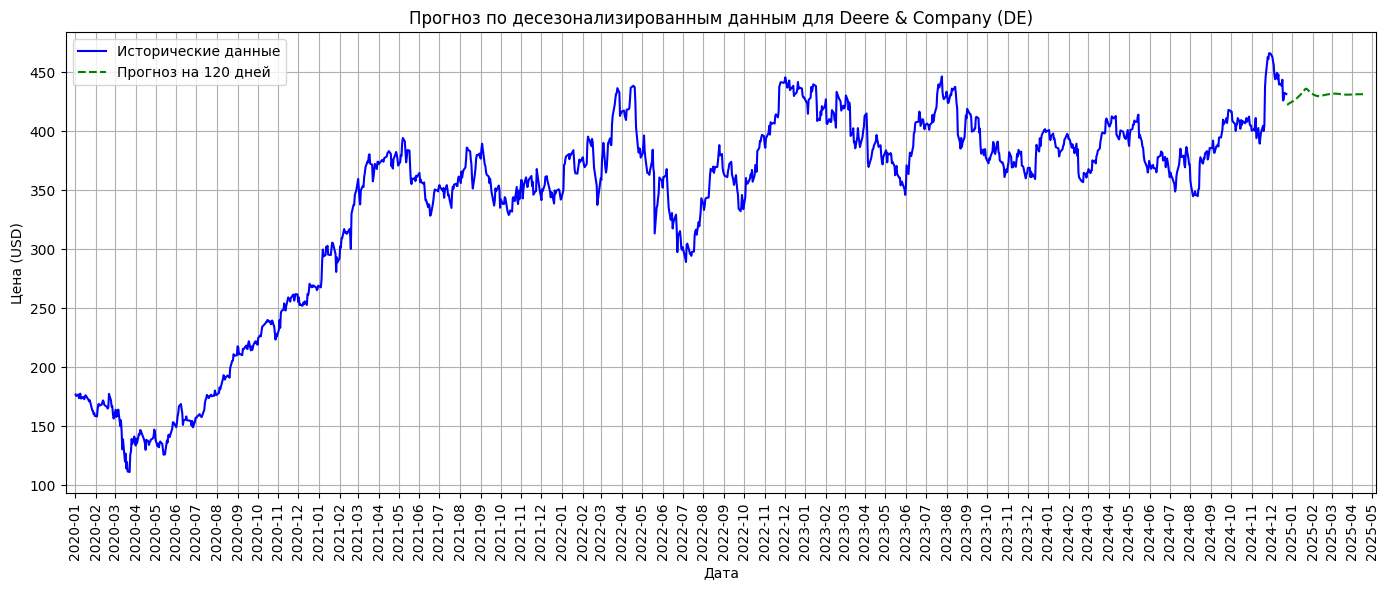

In [9]:

window_size = 50  
ema_deseasonalized = deseasonalized.ewm(span=window_size).mean()
forecast_days = 120  
last_known_date = de_data.index[-1] 
future_dates = [last_known_date + pd.Timedelta(days=i) for i in range(1, forecast_days + 1)]


future_ema_deseasonalized = []
last_values = deseasonalized[-window_size:].tolist()

for i in range(forecast_days):
    future_value = np.mean(last_values) 
    future_ema_deseasonalized.append(future_value)
    last_values.pop(0)
    last_values.append(future_value)

# Создание DataFrame для будущих значений
future_df_deseasonalized = pd.DataFrame(data=future_ema_deseasonalized, index=future_dates, columns=['Forecast'])

# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(de_data.index, de_close, label='Исторические данные', color='blue')
plt.plot(future_df_deseasonalized.index, future_df_deseasonalized['Forecast'] + seasonal.iloc[-1], label='Прогноз на 120 дней', color='green', linestyle='dashed')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(de_data.index[0] - pd.Timedelta(days=15), future_dates[-1] + pd.Timedelta(days=15))
plt.xlabel("Дата")
plt.ylabel("Цена (USD)")
plt.title("Прогноз по десезонализированным данным для Deere & Company (DE)")
plt.legend()
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90, ha="center")
plt.tight_layout()
plt.grid(True)
plt.show()

In [12]:

true_values = de_data["Close"][-forecast_days:]

forecast_values = future_df_deseasonalized['Forecast'] + seasonal.iloc[-1]
mae = mean_absolute_error(true_values, forecast_values)
rmse = np.sqrt(mean_squared_error(true_values, forecast_values))


print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 37.67341900370822
RMSE: 43.319130691573854


In [13]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')


adf_test(deseasonalized)

ADF Statistic: -1.7779669432838043
p-value: 0.3914540488512757
Critical Values:
	1%: -3.4355838322867998
	5%: -2.863851267837805
	10%: -2.5680005460145554


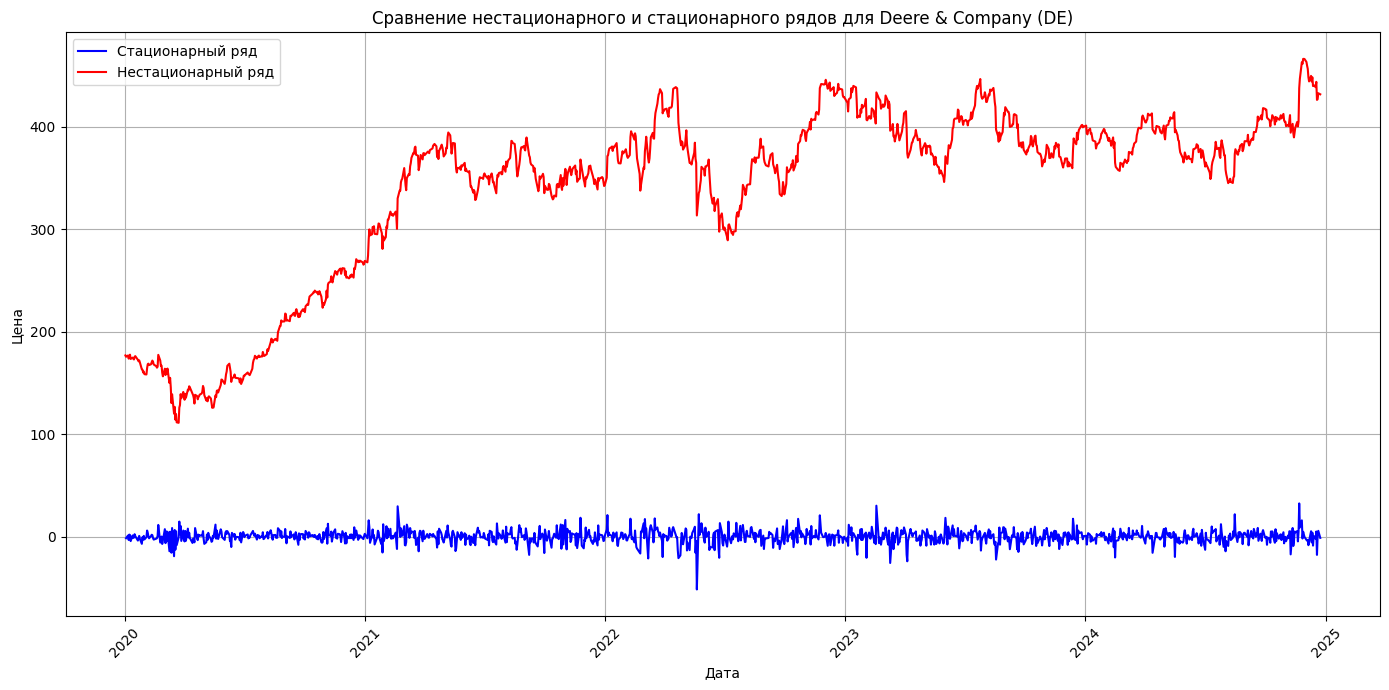

In [14]:

differenced_de = de_close.diff().dropna()


plt.figure(figsize=(14, 7))
plt.plot(differenced_de.index, differenced_de.values, label='Стационарный ряд', color='blue') 
plt.plot(de_close.index, de_close.values, label='Нестационарный ряд', color='red') 
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Сравнение нестационарного и стационарного рядов для Deere & Company (DE)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
def evaluate_arima_model_de(X, arima_order):
    train_size = int(len(X) * 0.7) 
    train, test = X[:train_size], X[train_size:]

    model = ARIMA(train, order=arima_order, trend='ct')
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast)) 

    return mae, rmse

In [18]:
# Настройка параметров ARIMA
p_values = range(0, 10)
d_values = [0]  # Дифференцирование не требуется, так как данные уже десезонализированы
q_values = [0]  # Параметр q также можно настроить

# Приводим индекс данных к ежедневному интервалу для удобства
deseasonalized.index = pd.date_range(start=deseasonalized.index[0], periods=len(deseasonalized), freq='D')

# Инициализация переменных для выбора наилучшей модели
best_score_ar, best_cfg_ar = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model_de(deseasonalized.values, order)  # Оценка модели ARIMA
                if mae < best_score_ar:  # Обновление наилучшей модели
                    best_score_ar, best_cfg_ar = mae, order
                print(f'AR{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

# Вывод наилучшей модели ARIMA
print(f'Лучшая модель AR{best_cfg_ar} MAE={best_score_ar:.3f}')


AR(0, 0, 0) MAE=114.790 RMSE=121.336
AR(1, 0, 0) MAE=93.816 RMSE=102.852
AR(2, 0, 0) MAE=94.049 RMSE=103.091
AR(3, 0, 0) MAE=94.533 RMSE=103.583
AR(4, 0, 0) MAE=93.173 RMSE=102.176
AR(5, 0, 0) MAE=92.510 RMSE=101.483
AR(6, 0, 0) MAE=92.022 RMSE=100.976
AR(7, 0, 0) MAE=90.317 RMSE=99.197
AR(8, 0, 0) MAE=90.251 RMSE=99.128
AR(9, 0, 0) MAE=88.953 RMSE=97.773
Лучшая модель AR(9, 0, 0) MAE=88.953


In [19]:

p_values = [0]  
d_values = [0]  
q_values = range(0, 10)  

# Приводим индекс данных к ежедневному интервалу
deseasonalized.index = pd.date_range(start=deseasonalized.index[0], periods=len(deseasonalized), freq='D')

# Инициализация переменных для выбора наилучшей модели MA
best_score_ma, best_cfg_ma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # Оценка модели MA с использованием функции для ARIMA
                mae, rmse = evaluate_arima_model_de(deseasonalized.values, order)
                if mae < best_score_ma:  # Обновление наилучшей модели
                    best_score_ma, best_cfg_ma = mae, order
                print(f'MA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue


print(f'Лучшая модель MA{best_cfg_ma} MAE={best_score_ma:.3f}')


MA(0, 0, 0) MAE=114.790 RMSE=121.336
MA(0, 0, 1) MAE=114.633 RMSE=121.225


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 2) MAE=114.406 RMSE=121.066
MA(0, 0, 3) MAE=114.503 RMSE=121.129
MA(0, 0, 4) MAE=114.232 RMSE=120.942
MA(0, 0, 5) MAE=114.353 RMSE=121.024
MA(0, 0, 6) MAE=114.166 RMSE=120.897
MA(0, 0, 7) MAE=91.295 RMSE=98.545
MA(0, 0, 8) MAE=114.565 RMSE=121.399


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 9) MAE=113.903 RMSE=120.712
Лучшая модель MA(0, 0, 7) MAE=91.295


In [20]:
# Оценка модели ARMA (AutoRegressive Moving Average)
p_values = range(0, 5)  # p от 0 до 4
d_values = [0]  # Для ARMA d всегда 0
q_values = range(0, 5)  # q от 0 до 4

# Приводим индекс данных к ежедневному интервалу
deseasonalized.index = pd.date_range(start=deseasonalized.index[0], periods=len(deseasonalized), freq='D')

# Инициализация переменных для выбора наилучшей модели ARMA
best_score_arma, best_cfg_arma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # Оценка модели ARMA с использованием функции для ARIMA (так как ARMA - это частный случай ARIMA)
                mae, rmse = evaluate_arima_model_de(deseasonalized.values, order)
                if mae < best_score_arma:  # Обновление наилучшей модели
                    best_score_arma, best_cfg_arma = mae, order
                print(f'ARMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

# Вывод наилучшей модели ARMA
print(f'Лучшая модель ARMA{best_cfg_arma} MAE={best_score_arma:.3f}')


ARMA(0, 0, 0) MAE=114.790 RMSE=121.336
ARMA(0, 0, 1) MAE=114.633 RMSE=121.225


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(0, 0, 2) MAE=114.406 RMSE=121.066
ARMA(0, 0, 3) MAE=114.503 RMSE=121.129
ARMA(0, 0, 4) MAE=114.232 RMSE=120.942
ARMA(1, 0, 0) MAE=93.816 RMSE=102.852
ARMA(1, 0, 1) MAE=94.033 RMSE=103.073
ARMA(1, 0, 2) MAE=94.650 RMSE=103.703
ARMA(1, 0, 3) MAE=92.859 RMSE=101.852
ARMA(1, 0, 4) MAE=92.000 RMSE=100.954
ARMA(2, 0, 0) MAE=94.049 RMSE=103.091


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 0, 1) MAE=93.878 RMSE=102.913
ARMA(2, 0, 2) MAE=93.763 RMSE=102.797
ARMA(2, 0, 3) MAE=90.689 RMSE=99.587
ARMA(2, 0, 4) MAE=92.099 RMSE=101.056
ARMA(3, 0, 0) MAE=94.533 RMSE=103.583
ARMA(3, 0, 1) MAE=94.673 RMSE=103.724
ARMA(3, 0, 2) MAE=91.149 RMSE=100.098


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 0, 3) MAE=93.924 RMSE=102.920
ARMA(3, 0, 4) MAE=96.298 RMSE=105.293
ARMA(4, 0, 0) MAE=93.173 RMSE=102.176
ARMA(4, 0, 1) MAE=90.623 RMSE=99.518
ARMA(4, 0, 2) MAE=88.346 RMSE=97.211


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(4, 0, 3) MAE=100.051 RMSE=109.684


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(4, 0, 4) MAE=86.507 RMSE=94.990
Лучшая модель ARMA(4, 0, 4) MAE=86.507


In [25]:
# Задаем параметры p, d, q для поиска лучшей модели ARIMA
p_values = range(0, 3)  # Параметры p
d_values = range(0, 3)  # Параметры d
q_values = range(0, 3)  # Параметры q

# Приводим индекс данных к ежедневному интервалу для удобства
deseasonalized.index = pd.date_range(start=deseasonalized.index[0], periods=len(deseasonalized), freq='D')

# Инициализация переменных для выбора наилучшей модели ARIMA
best_score_arima, best_cfg_arima = float("inf"), None

# Перебор всех сочетаний параметров ARIMA
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # Оценка модели ARIMA с использованием десезонализированных данных
                mae, rmse = evaluate_arima_model_de(deseasonalized.values, order)  # evaluate_arima_model_de - это функция для оценки модели
                if mae < best_score_arima:  # Обновление наилучшей модели
                    best_score_arima, best_cfg_arima = mae, order
                print(f'ARIMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

# Вывод наилучшей модели ARIMA
print(f'Лучшая модель ARIMA{best_cfg_arima} MAE={best_score_arima:.3f}')


ARIMA(0, 0, 0) MAE=114.790 RMSE=121.336
ARIMA(0, 0, 1) MAE=114.633 RMSE=121.225


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) MAE=114.406 RMSE=121.066
ARIMA(1, 0, 0) MAE=93.816 RMSE=102.852
ARIMA(1, 0, 1) MAE=94.033 RMSE=103.073
ARIMA(1, 0, 2) MAE=94.650 RMSE=103.703
ARIMA(2, 0, 0) MAE=94.049 RMSE=103.091


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 1) MAE=93.878 RMSE=102.913
ARIMA(2, 0, 2) MAE=93.763 RMSE=102.797
Лучшая модель ARIMA(2, 0, 2) MAE=93.763


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

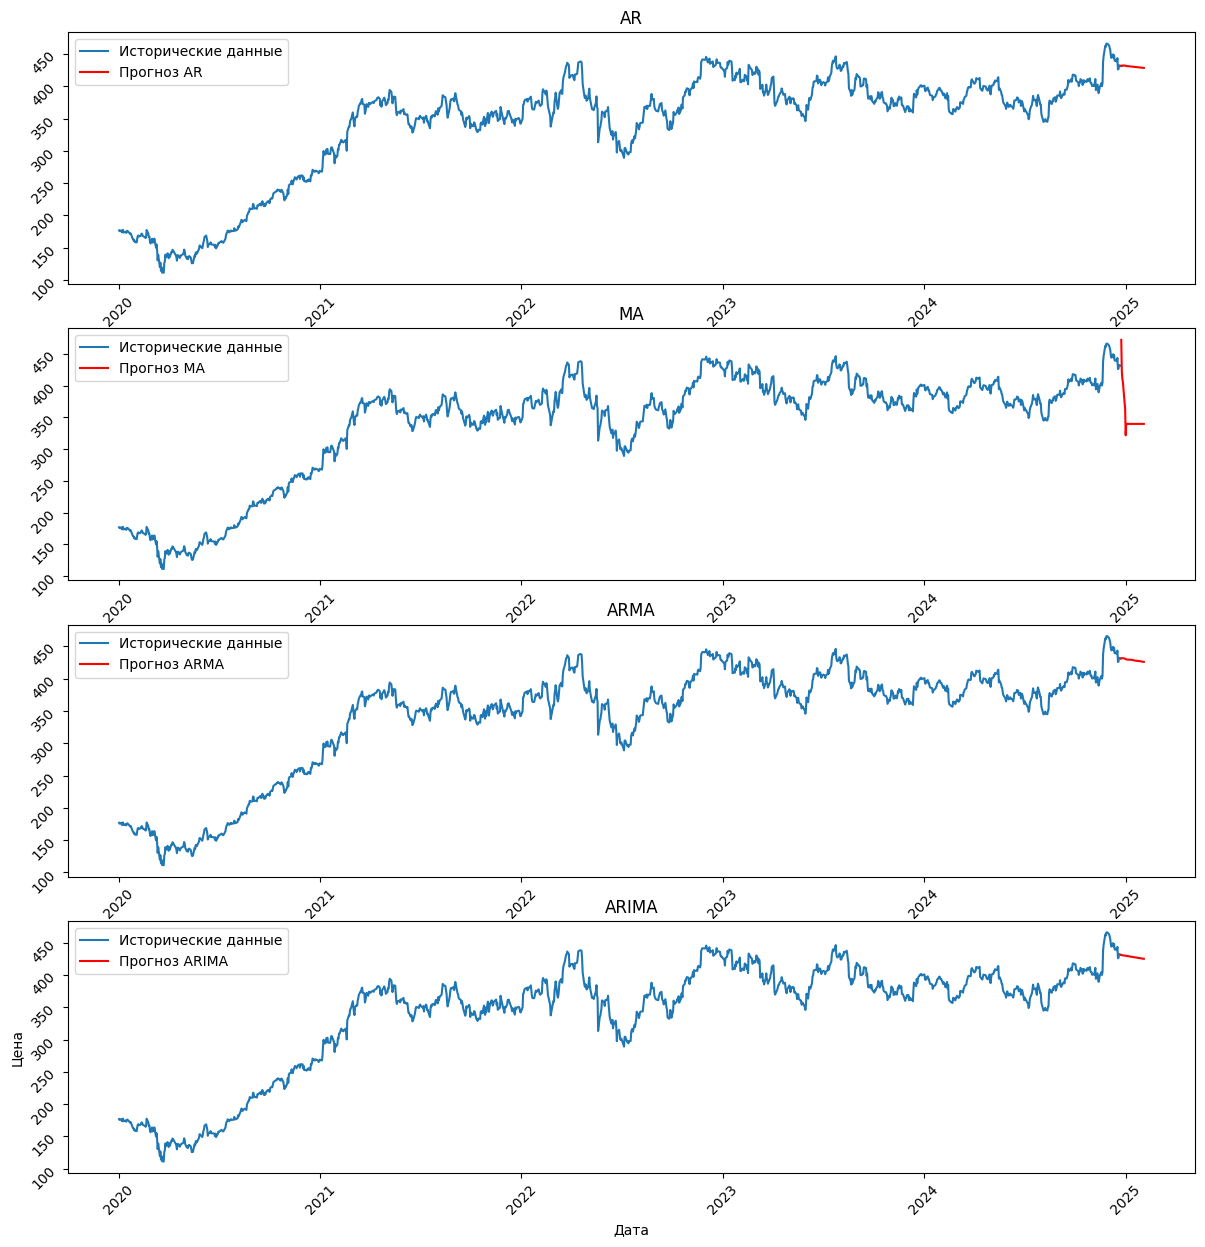

In [37]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Загрузка данных о ценах для Deere & Company (DE)
de_data = yf.download('DE', start='2020-01-01', end='2024-12-31')

# Берем только цены закрытия
de_close = de_data['Close']

# Предположим, что вы уже определили лучшие параметры для моделей:
best_cfg_ar = (9, 0, 0)    # Пример: AR(1) модель
best_cfg_ma = (0, 0, 7)    # Пример: MA(1) модель
best_cfg_arma = (4, 0, 4)  # Пример: ARMA(1,1) модель
best_cfg_arima = (2, 0, 2) # Пример: ARIMA(1,1,1) модель

# Модели AR, MA, ARMA и ARIMA
model_ar = ARIMA(de_close, order=best_cfg_ar)
model_ma = ARIMA(de_close, order=best_cfg_ma)
model_arma = ARIMA(de_close, order=best_cfg_arma)
model_arima = ARIMA(de_close, order=best_cfg_arima)

# Обучаем модели
model_fit_ar = model_ar.fit()
model_fit_ma = model_ma.fit()
model_fit_arma = model_arma.fit()
model_fit_arima = model_arima.fit()

# Прогнозируем на 30 шагов вперед
forecast_ar = model_fit_ar.forecast(steps=30)
forecast_ma = model_fit_ma.forecast(steps=30)
forecast_arma = model_fit_arma.forecast(steps=30)
forecast_arima = model_fit_arima.forecast(steps=30)


forecast_index = pd.date_range(start=de_close.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')


fig, ax = plt.subplots(4, figsize=(12, 12))
fig.tight_layout()


for i in range(4):
    ax[i].plot(de_close.index, de_close, label='Исторические данные')

# Прогнозы с одинаковыми индексами для всех моделей
ax[0].plot(forecast_index, forecast_ar, color='red', label='Прогноз AR')
ax[1].plot(forecast_index, forecast_ma, color='red', label='Прогноз MA')
ax[2].plot(forecast_index, forecast_arma, color='red', label='Прогноз ARMA')
ax[3].plot(forecast_index, forecast_arima, color='red', label='Прогноз ARIMA')


ax[0].title.set_text("AR")
ax[1].title.set_text("MA")
ax[2].title.set_text("ARMA")
ax[3].title.set_text("ARIMA")


plt.xlabel('Дата')
plt.ylabel('Цена')


for i in range(4):
    ax[i].tick_params(labelrotation=45)


for i in range(4):
    ax[i].legend()


plt.show()


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

test_data = deseasonalized[-30:]

forecast_ar_values = model_fit_ar.forecast(steps=30)
forecast_ma_values = model_fit_ma.forecast(steps=30)
forecast_arma_values = model_fit_arma.forecast(steps=30)
forecast_arima_values = model_fit_arima.forecast(steps=30)


metrics = {
    "Model": ["AR", "MA", "ARMA", "ARIMA"],
    "MAE": [
        mean_absolute_error(test_data, forecast_ar_values),
        mean_absolute_error(test_data, forecast_ma_values),
        mean_absolute_error(test_data, forecast_arma_values),
        mean_absolute_error(test_data, forecast_arima_values),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test_data, forecast_ar_values)),
        np.sqrt(mean_squared_error(test_data, forecast_ma_values)),
        np.sqrt(mean_squared_error(test_data, forecast_arma_values)),
        np.sqrt(mean_squared_error(test_data, forecast_arima_values)),
    ],
    "MAPE": [
        mean_absolute_percentage_error(test_data, forecast_ar_values),
        mean_absolute_percentage_error(test_data, forecast_ma_values),
        mean_absolute_percentage_error(test_data, forecast_arma_values),
        mean_absolute_percentage_error(test_data, forecast_arima_values),
    ],
}

metrics_df = pd.DataFrame(metrics)

print(metrics_df)


   Model        MAE        RMSE      MAPE
0     AR  20.814231   23.659172  0.048385
1     MA  98.713148  102.115220  0.226456
2   ARMA  21.495736   24.155168  0.049868
3  ARIMA  21.750517   24.308424  0.050367


Таким образом, для временного ряда Deere & Company (DE) модель AR является наиболее подходящей, однако ARMA и ARIMA все еще могут быть полезны для более сложных данных, если их характеристики изменяются со временем